# 🏥 NCBI Disease Named Entity Recognition using CRF

This notebook implements a **Conditional Random Field (CRF)** model for biomedical Named Entity Recognition (NER) to identify disease mentions in text using the **NCBI Disease Corpus**.

## Overview
- **Task**: Sequence labeling for disease entity recognition
- **Model**: Conditional Random Field (CRF)
- **Dataset**: NCBI Disease Corpus (CoNLL format)
- **Evaluation**: Precision, Recall, F1-Score, Accuracy per class, ROC-AUC

---

In [1]:
# Import Required Libraries
import requests
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk import pos_tag
import nltk
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
import re
import os
import warnings
warnings.filterwarnings('ignore')

## 0. Setup & NLTK Downloads

In [2]:
# --- 0. SETUP & DOWNLOADER ---
print(">>> Initializing...")
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

>>> Initializing...


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/scorpiontaj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/scorpiontaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Data Loading

We use the NCBI Disease Corpus in CoNLL format, which contains:
- **Training set**: For model training
- **Development set**: For hyperparameter tuning  
- **Test set**: For final evaluation

In [3]:
# URLs for the NCBI Disease Corpus (CoNLL format)
DATA_URLS = {
    'train': 'https://raw.githubusercontent.com/spyysalo/ncbi-disease/master/conll/train.tsv',
    'dev': 'https://raw.githubusercontent.com/spyysalo/ncbi-disease/master/conll/devel.tsv',
    'test': 'https://raw.githubusercontent.com/spyysalo/ncbi-disease/master/conll/test.tsv'
}

In [4]:
def load_conll_data(url):
    """
    Downloads and parses CoNLL format data from a URL.
    Returns a list of sentences, where each sentence is a list of (word, label) tuples.
    """
    print(f"Downloading data from {url}...")
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download data: {response.status_code}")

    content = response.text
    sentences = []
    current_sent = []

    for line in content.strip().split('\n'):
        line = line.strip()
        if not line:
            if current_sent:
                sentences.append(current_sent)
                current_sent = []
        else:
            # Expected format: Word \t Label
            parts = line.split('\t')
            if len(parts) >= 2:
                word = parts[0]
                label = parts[-1] # Label is usually the last column
                current_sent.append((word, label))

    if current_sent:
        sentences.append(current_sent)

    return sentences

## 2. Feature Engineering

Features extracted for each token include:
- **Lexical**: Word form, stem, prefixes, suffixes
- **Contextual**: Previous/next word features, POS tags
- **Orthographic**: Capitalization, digits, special characters

In [5]:
stemmer = PorterStemmer()

def get_orthographic_features(word):
    """Orthographic features from Table 1 of the paper"""
    return {
        'is_title': word.istitle(),
        'is_all_caps': word.isupper(),
        'is_lower': word.islower(),
        'is_digit': word.isdigit(),
        'is_alnum': word.isalnum(),
        'has_dash': '-' in word,
        'has_slash': '/' in word,
        'has_greek': bool(re.search(r'(alpha|beta|gamma|delta|I|II|III|IV)', word, re.I))
    }

In [6]:
def sent2features(sent):
    """
    Extracts features for a full sentence.
    Includes: Context (prev/next word), POS tags (generated), Stemming, Affixes.
    """
    # Generate POS tags for the whole sentence first (better accuracy)
    words = [token for token, label in sent]
    pos_tags = [pos for token, pos in pos_tag(words)]

    features_list = []

    for i in range(len(sent)):
        word = sent[i][0]
        postag = pos_tags[i]
        stemmed_word = stemmer.stem(word)

        # Base Features
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word.stem': stemmed_word,
            'postag': postag,
            'prefix-1': word[:1],
            'prefix-2': word[:2],
            'prefix-3': word[:3],
            'suffix-1': word[-1:],
            'suffix-2': word[-2:],
            'suffix-3': word[-3:],
            'suffix-4': word[-4:],
        }

        features.update(get_orthographic_features(word))

        # Context: Previous Word
        if i > 0:
            word1 = sent[i-1][0]
            postag1 = pos_tags[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:postag': postag1,
                '-1:word.istitle()': word1.istitle(),
            })
        else:
            features['BOS'] = True

        # Context: Next Word
        if i < len(sent)-1:
            word1 = sent[i+1][0]
            postag1 = pos_tags[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:postag': postag1,
                '+1:word.istitle()': word1.istitle(),
            })
        else:
            features['EOS'] = True

        features_list.append(features)

    return features_list

In [7]:
def sent2labels(sent):
    return [label for token, label in sent]

## 3. Data Processing & Feature Extraction

In [8]:
print(">>> Processing Training Data...")
train_sents = load_conll_data(DATA_URLS['train'])
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

print(">>> Processing Test Data...")
test_sents = load_conll_data(DATA_URLS['test'])
X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

>>> Processing Training Data...
>>> Processing Test Data...
>>> Processing Test Data...


## 4. Model Training

Using **sklearn-crfsuite** with L-BFGS optimization algorithm.

In [9]:
# --- 3. TRAIN MODEL ---
print(">>> Training Conditional Random Field (CRF)...")
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)
crf.fit(X_train, y_train)

>>> Training Conditional Random Field (CRF)...


loading training data to CRFsuite: 100%|██████████| 5432/5432 [00:01<00:00, 3965.06it/s]




Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 52561
Seconds required: 0.250

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.09  loss=46804.50 active=52072 feature_norm=1.00
Iter 2   time=0.04  loss=44273.89 active=50369 feature_norm=1.11
..9....10
Number of features: 52561
Seconds required: 0.250

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.09  loss=46804.50 active=52072 feature_norm=1.00
Iter 2   time=0.04  loss=44273.89 active=50369 feature_norm=1.11
Iter 3   time=0.04  loss=41315.66 active=50517 feature_norm=1.28
Iter 4   time=0.04  loss=37530.80

,algorithm,'lbfgs'
,min_freq,None
,all_possible_states,None
,all_possible_transitions,True
,c1,0.1
,c2,0.1
,max_iterations,100
,num_memories,None
,epsilon,None
,period,None
,delta,None


### Learning Curve Analysis

Since CRF uses L-BFGS optimization (not epoch-based gradient descent), we visualize learning curves by training on increasing portions of the data and measuring performance metrics.

In [ ]:
# --- LEARNING CURVE ---
from sklearn.model_selection import learning_curve
from sklearn_crfsuite import metrics as crf_metrics

print(">>> Generating Learning Curves (this may take a few minutes)...")

# Define training sizes to evaluate
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Storage for metrics
train_f1_scores = []
test_f1_scores = []
train_accuracies = []
test_accuracies = []

# Get disease labels for F1 calculation
disease_labels = [l for l in crf.classes_ if l != 'O']

for size in train_sizes:
    # Calculate number of samples
    n_samples = int(len(X_train) * size)

    # Subset of training data
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Train a new CRF model on the subset
    crf_temp = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True,
        verbose=False
    )
    crf_temp.fit(X_train_subset, y_train_subset)

    # Predict on training subset and test set
    y_train_pred = crf_temp.predict(X_train_subset)
    y_test_pred = crf_temp.predict(X_test)

    # Calculate F1 scores
    train_f1 = crf_metrics.flat_f1_score(y_train_subset, y_train_pred, average='weighted', labels=disease_labels)
    test_f1 = crf_metrics.flat_f1_score(y_test, y_test_pred, average='weighted', labels=disease_labels)

    # Calculate accuracies
    y_train_flat = [label for sent in y_train_subset for label in sent]
    y_train_pred_flat = [label for sent in y_train_pred for label in sent]
    y_test_flat_temp = [label for sent in y_test for label in sent]
    y_test_pred_flat = [label for sent in y_test_pred for label in sent]

    train_acc = accuracy_score(y_train_flat, y_train_pred_flat)
    test_acc = accuracy_score(y_test_flat_temp, y_test_pred_flat)

    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"  Training size: {size*100:.0f}% ({n_samples} sentences) - Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")

# Convert train sizes to actual sample counts for plotting
train_sample_counts = [int(len(X_train) * s) for s in train_sizes]

# Plot Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: F1-Score Learning Curve
axes[0].plot(train_sample_counts, train_f1_scores, 'o-', color='blue', label='Training F1-Score', linewidth=2, markersize=8)
axes[0].plot(train_sample_counts, test_f1_scores, 'o-', color='red', label='Validation F1-Score', linewidth=2, markersize=8)
axes[0].fill_between(train_sample_counts, train_f1_scores, test_f1_scores, alpha=0.1, color='gray')
axes[0].set_xlabel('Number of Training Sentences', fontsize=12)
axes[0].set_ylabel('F1-Score (Disease Tags)', fontsize=12)
axes[0].set_title('Learning Curve - F1-Score', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: Accuracy Learning Curve
axes[1].plot(train_sample_counts, train_accuracies, 'o-', color='green', label='Training Accuracy', linewidth=2, markersize=8)
axes[1].plot(train_sample_counts, test_accuracies, 'o-', color='orange', label='Validation Accuracy', linewidth=2, markersize=8)
axes[1].fill_between(train_sample_counts, train_accuracies, test_accuracies, alpha=0.1, color='gray')
axes[1].set_xlabel('Number of Training Sentences', fontsize=12)
axes[1].set_ylabel('Accuracy (All Tokens)', fontsize=12)
axes[1].set_title('Learning Curve - Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("\n✅ Learning curves generated successfully!")

>>> Generating Learning Curves (this may take a few minutes)...
  Training size: 10% (543 sentences) - Train F1: 0.9963, Test F1: 0.6268
  Training size: 10% (543 sentences) - Train F1: 0.9963, Test F1: 0.6268
  Training size: 20% (1086 sentences) - Train F1: 0.9937, Test F1: 0.7434
  Training size: 20% (1086 sentences) - Train F1: 0.9937, Test F1: 0.7434
  Training size: 30% (1629 sentences) - Train F1: 0.9934, Test F1: 0.7614
  Training size: 30% (1629 sentences) - Train F1: 0.9934, Test F1: 0.7614
  Training size: 40% (2172 sentences) - Train F1: 0.9929, Test F1: 0.7896
  Training size: 40% (2172 sentences) - Train F1: 0.9929, Test F1: 0.7896
  Training size: 50% (2716 sentences) - Train F1: 0.9903, Test F1: 0.7933
  Training size: 50% (2716 sentences) - Train F1: 0.9903, Test F1: 0.7933
  Training size: 60% (3259 sentences) - Train F1: 0.9887, Test F1: 0.7933
  Training size: 60% (3259 sentences) - Train F1: 0.9887, Test F1: 0.7933
  Training size: 70% (3802 sentences) - Train F1: 

## 5. Model Evaluation

### Classification Report with Per-Class Accuracy

In [ ]:
# --- EVALUATION ---
print(">>> Predicting on Test Set...")
y_pred = crf.predict(X_test)

# Flatten predictions and labels
y_test_flat = [label for sent in y_test for label in sent]
y_pred_flat = [label for sent in y_pred for label in sent]

# Get all labels (including 'O')
all_labels = list(crf.classes_)
disease_labels = [l for l in all_labels if l != 'O']

# Overall Accuracy
overall_accuracy = accuracy_score(y_test_flat, y_pred_flat)

# Per-class accuracy calculation
print("\n" + "="*60)
print("              📊 EVALUATION RESULTS")
print("="*60)

print(f"\n🎯 Overall Token Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# Per-class accuracy
print("\n" + "-"*60)
print("              PER-CLASS ACCURACY")
print("-"*60)
for label in all_labels:
    # Get indices where true label is this class
    indices = [i for i, t in enumerate(y_test_flat) if t == label]
    if indices:
        correct = sum(1 for i in indices if y_pred_flat[i] == label)
        class_acc = correct / len(indices)
        print(f"  {label:12s}: {class_acc:.4f} ({class_acc*100:.2f}%)  [Support: {len(indices)}]")

# Classification Report (Precision, Recall, F1)
print("\n" + "-"*60)
print("         CLASSIFICATION REPORT (Disease Tags)")
print("-"*60)
print(metrics.flat_classification_report(y_test, y_pred, labels=disease_labels, digits=3))

>>> Predicting on Test Set...

              📊 EVALUATION RESULTS

🎯 Overall Token Accuracy: 0.9755 (97.55%)

------------------------------------------------------------
              PER-CLASS ACCURACY
------------------------------------------------------------
  O           : 0.9915 (99.15%)  [Support: 22450]
  B-Disease   : 0.7896 (78.96%)  [Support: 960]
  I-Disease   : 0.8096 (80.96%)  [Support: 1087]

------------------------------------------------------------
         CLASSIFICATION REPORT (Disease Tags)
------------------------------------------------------------
              precision    recall  f1-score   support

   B-Disease      0.872     0.790     0.829       960
   I-Disease      0.848     0.810     0.828      1087

   micro avg      0.859     0.800     0.829      2047
   macro avg      0.860     0.800     0.829      2047
weighted avg      0.859     0.800     0.829      2047



### ROC Curve & AUC Score

>>> Calculating ROC/AUC for Disease Detection...


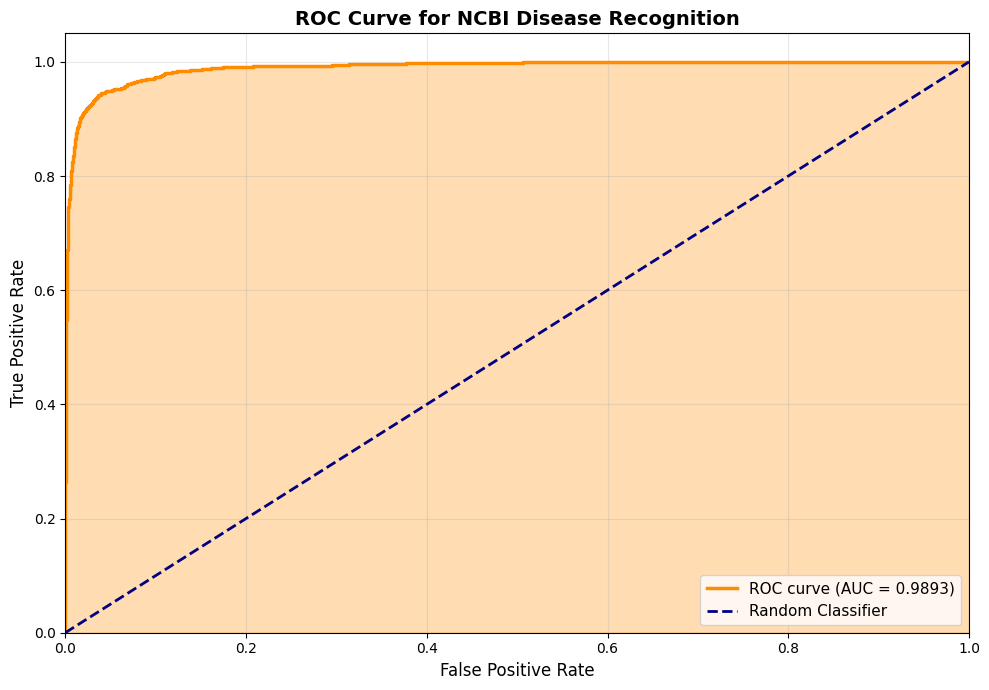


✅ AUC Score: 0.9893


In [ ]:
# --- ROC & AUC ---
print(">>> Calculating ROC/AUC for Disease Detection...")

# Get probability margins (confidence scores) for every token
y_probs = crf.predict_marginals(X_test)

# Flatten data to token-level for binary classification (Disease vs Not Disease)
y_probs_flat = [token_probs for sent in y_probs for token_probs in sent]

# Binarize: 1 if the true label is part of a disease, 0 otherwise
y_test_binary = [1 if label != 'O' else 0 for label in y_test_flat]

# Score: Sum of probabilities for all Disease tags
y_score_binary = []
disease_tags = [tag for tag in crf.classes_ if tag != 'O']

for prob_dict in y_probs_flat:
    p_disease = sum(prob_dict.get(tag, 0.0) for tag in disease_tags)
    y_score_binary.append(p_disease)

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_score_binary)
roc_auc = auc(fpr, tpr)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve for NCBI Disease Recognition', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

print(f"\n✅ AUC Score: {roc_auc:.4f}")

### Confusion Matrix

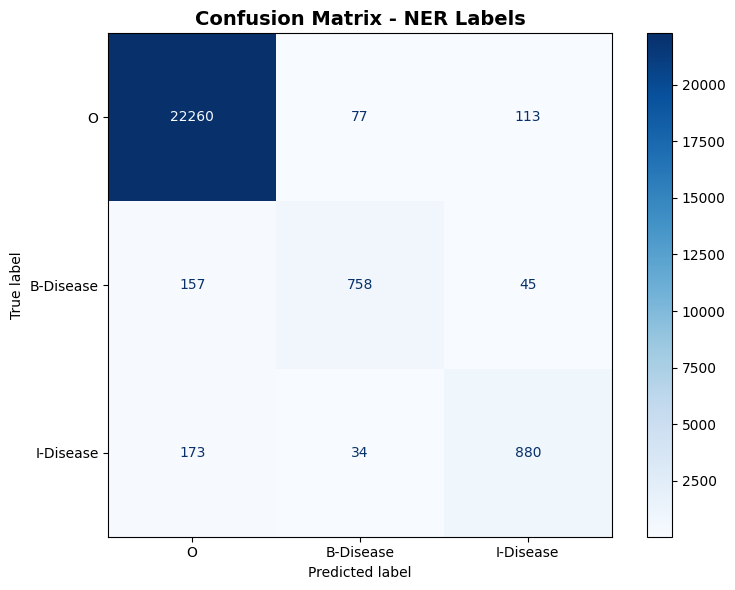

In [ ]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=all_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - NER Labels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()